# Mandelbrot CPU vs GPU

## Mandelbrot Set:
$$f_c^n = f_c(f_c^{n-1})$$

$$f_c(z) = z^2 + c$$

$$z_{n+1} = z_n^2 + c$$

$$\lVert z_n \rVert > 2$$ 

# Installation

Questo programma è scritto e eseguito all'interno di un [Jupyter notebook](https://jupyter.org/).  

È possibile eseguirlo su installazioni cloud per esempio andando su questa pagina: <https://jupyter.org/try-jupyter/lab/>.  
Quì è possibile accedere ad una implementazione online gratuita, che consente di caricare e girare questo notebook su CPU.

Altrimenti, è possibile installare l'ambiente anche sul proprio PC.  
Un software consigliato per la gestione di ambienti virtuali e pacchetti è [Anaconda](https://docs.anaconda.com/).  
Se si possiede una GPU Nvidia, è possibile installare [CUDA](https://developer.nvidia.com/cuda-toolkit) per girare il codice anche sulla GPU.

## Dependencies
Il codice è scritto in Python 3.x  

I pacchetti necessari sono `numpy` e `matplotlib`.  
Il pacchetto `pycuda` è necessario solo in caso di GPU.

# Libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

In [2]:
try:
    import pycuda.autoinit
    import pycuda.gpuarray as gpuarray
    from pycuda.elementwise import ElementwiseKernel
    use_gpu = True
except ImportError:
    use_gpu = False

use_gpu

True

# Numpy

This code is executed on CPU only

In [3]:
# compute the entire matrix of points
def mandelbrot_cpu(c, maxiter):
    output = np.zeros(c.shape)
    z = np.zeros(c.shape, np.complex64)
    for it in range(maxiter+1):
        notdone = np.less(z.real*z.real + z.imag*z.imag, 4.0)
        output[notdone] = it
        z[notdone] = z[notdone]**2 + c[notdone]
    output[output == maxiter] = 0
    return output

# create the matrix
def mandelbrot_set_cpu(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    n3 = mandelbrot_cpu(c,maxiter)
    return (r1,r2,n3.T) 

# PyCUDA

This code is executed on GPU

In [4]:
# kernel that will be executed on a single cell of the GPU
if use_gpu: complex_num32 = ElementwiseKernel(
    "float *q_real, float *q_imag, int *output, int maxiter",
    """
    {
        float real_tmp;
        //float real = q_real[i];
        //float imag = q_imag[i];
        float real = 0;
        float imag = 0;

        output[i] = 0;

        for(int curiter = 0; curiter < maxiter; curiter++) {
            real_tmp = real*real - imag*imag + q_real[i];
            imag = 2 * real*imag + q_imag[i];
            real = real_tmp;
            if (real*real + imag*imag >= 4.0f){
                output[i] = curiter;
                break;
           }
        }
        
    }
    """,
    "complex_num",
    preamble="""#include <pycuda-complex.hpp>
                #include <stdio.h>""",)

# move the matrix to the GPU and compute all the points
def mandelbrot_gpu(c, maxiter):
    r_gpu = gpuarray.to_gpu(c.real)
    i_gpu = gpuarray.to_gpu(c.imag)
    
    iterations_gpu = gpuarray.to_gpu(np.empty(c.shape, dtype=np.int32))

    complex_num32(r_gpu, i_gpu, iterations_gpu, maxiter)

    return iterations_gpu.get()

# create the matrix
def mandelbrot_set_gpu(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    orig_shape = c.shape
    c = np.ravel(c)
    n3 = mandelbrot_gpu(c, maxiter)
    n3 = n3.reshape(orig_shape)
    return (r1,r2,n3.T)

-----
# Execution

In [5]:
# Parameters
xmin = -2.0; xmax = 0.5
ymin = -1.25; ymax = 1.25
dim_cpu = 9000; dim_gpu = 50000
maxiter = 100

In [6]:
# compute on CPU
%time cpu_res = mandelbrot_set_cpu(xmin, xmax, ymin, ymax, dim_cpu, dim_cpu, maxiter)

CPU times: user 26.2 s, sys: 8.1 s, total: 34.3 s
Wall time: 34.3 s


In [7]:
# compute on GPU (only if pycuda is installed)
%time gpu_res = mandelbrot_set_gpu(xmin, xmax, ymin, ymax, dim_gpu, dim_gpu, maxiter) \
    if use_gpu else mandelbrot_set_cpu(0,0,0,0,1,1,0)

CPU times: user 28.3 s, sys: 3.5 s, total: 31.8 s
Wall time: 32 s


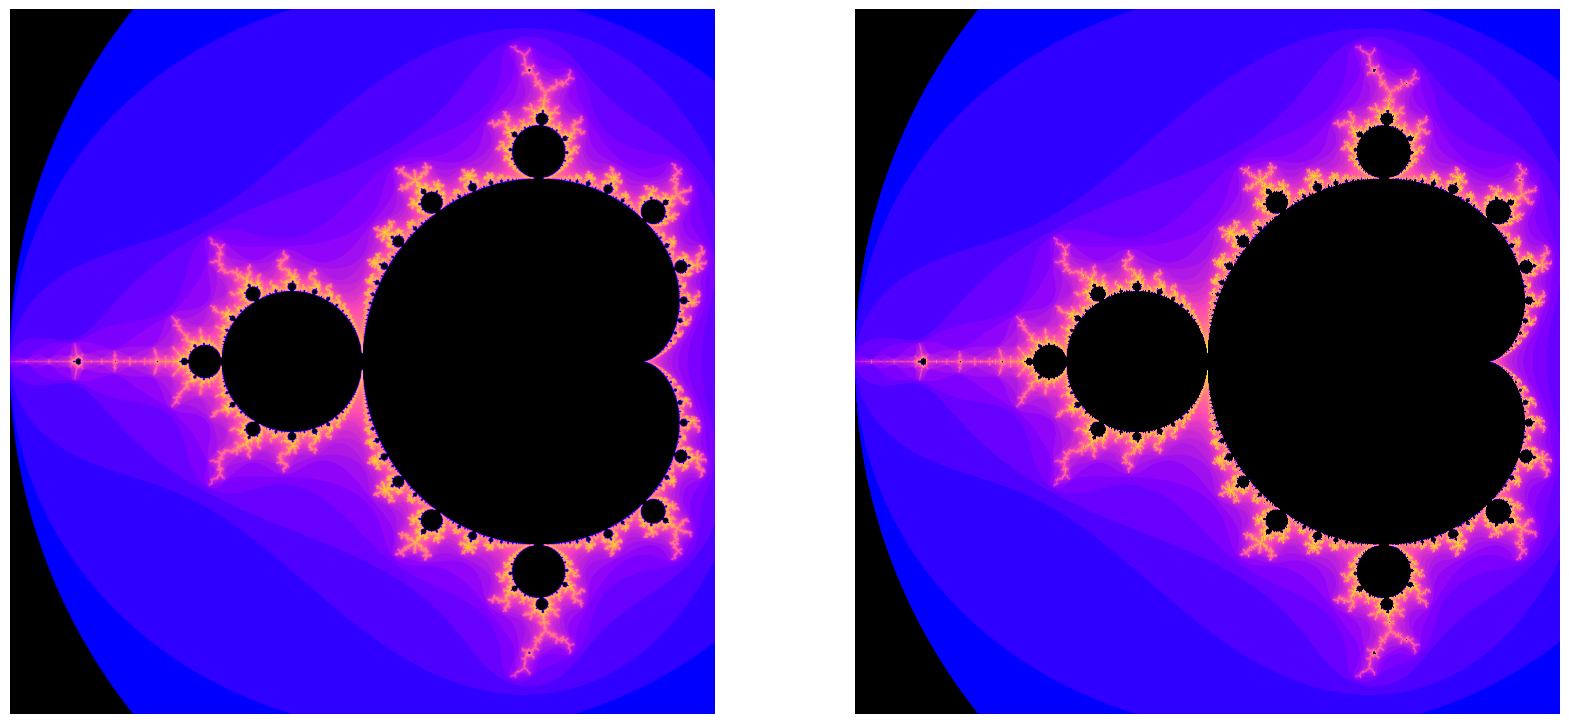

In [8]:
percentages = [0, 1, 0, 1]  # plot the entire figure

slice_cpu = (len(cpu_res[2]) * np.array(percentages)).astype(int)
slice_gpu = (len(gpu_res[2]) * np.array(percentages)).astype(int)

data_cpu = cpu_res[2].T[slice_cpu[0]:slice_cpu[1],slice_cpu[2]:slice_cpu[3]]
data_gpu = gpu_res[2].T[slice_gpu[0]:slice_gpu[1],slice_gpu[2]:slice_gpu[3]]

norm = colors.PowerNorm(0.3)

fig, axs = plt.subplots(1, 2, figsize=(20,20))
im0 = axs[0].imshow(data_cpu, cmap='gnuplot2', norm=norm)
axs[0].axis('off')

im1 = axs[1].imshow(data_gpu, cmap='gnuplot2', norm=norm)
axs[1].axis('off')

plt.show()

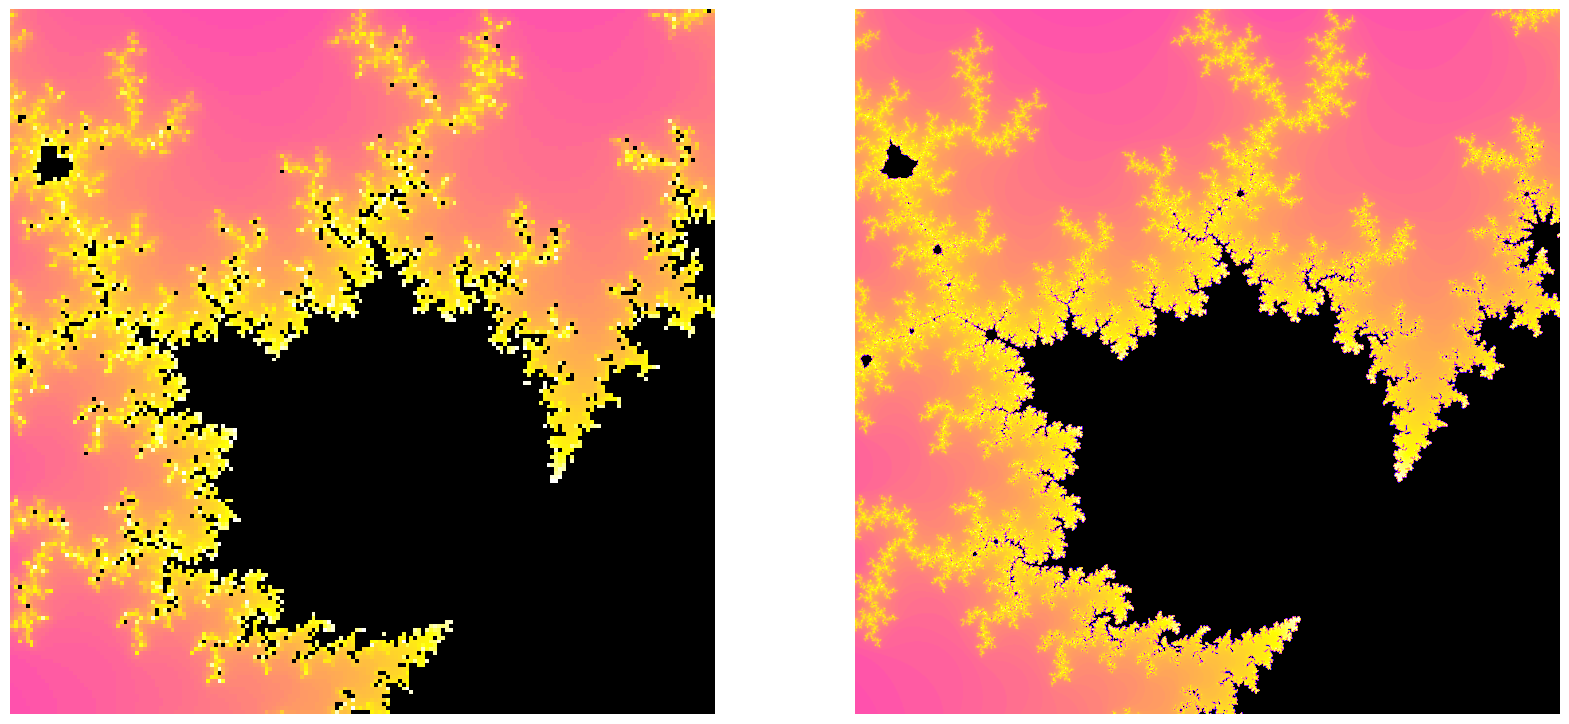

In [9]:
percentages = [0.165, 0.185, 0.705, 0.725]  # plot only a portion of the figure

slice_cpu = (len(cpu_res[2]) * np.array(percentages)).astype(int)
slice_gpu = (len(gpu_res[2]) * np.array(percentages)).astype(int)

data_cpu = cpu_res[2].T[slice_cpu[0]:slice_cpu[1],slice_cpu[2]:slice_cpu[3]]
data_gpu = gpu_res[2].T[slice_gpu[0]:slice_gpu[1],slice_gpu[2]:slice_gpu[3]]

norm = colors.PowerNorm(0.3)

fig, axs = plt.subplots(1, 2, figsize=(20,20))
axs[0].imshow(data_cpu, cmap='gnuplot2', norm=norm)
axs[0].axis('off')
axs[1].imshow(data_gpu, cmap='gnuplot2', norm=norm)
axs[1].axis('off')
plt.show()